### import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from datetime import datetime
import datetime as dt
from astropy.time import Time
import pymc3 as pm
import arviz as az
from astropy.time import Time
import csv
import sys
thisWorkColor = '#1f77b4'
T21Color = '#ff7f0e'


In [20]:
def getT21Values(compName):
    """
    get the proper motion values for the comp from digitised T21 plot
    """
    
    mjd_array = []
    mas_array = []

    with open('oldDATA/{}.csv'.format(compName)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            mjd = float(row[0])
            mas = float(row[1])
            mjd_array.append(mjd)
            mas_array.append(mas)
            
    ## typecast to numpy array cos we about to do some np magic
    mjd_array = np.array(mjd_array)
    mas_array = np.array(mas_array)
    
    ## le magic
    comp_mjd = mjd_array[0::3]
    comp_mas = mas_array[0::3]
    comp_mas_upper = mas_array[1::3] - comp_mas
    comp_mas_lower = comp_mas - mas_array[2::3]
    
    return comp_mjd, comp_mas, comp_mas_upper, comp_mas_lower



# def getTANAMIValues(compName):
#     """
#     get the proper motion values for the comp from TANAMI
#     """
    
#     mjd_array = []
#     mas_array = []
#     mas_err_array = []

#     with open('oldDATA/{}.csv'.format(compName)) as csv_file:
#         csv_reader = csv.reader(csv_file, delimiter=',')
#         for row in csv_reader:
#             mjd = float(row[0])
#             mas = float(row[1])
#             mas_err = float(row[2])
#             mjd_array.append(mjd)
#             mas_array.append(mas)
#             mas_err_array.append(mas_err)
            
#     ## typecast to numpy array cos we about to do some np magic
#     mjd_array = np.array(mjd_array)
#     mas_array = np.array(mas_array)
#     mas_err_array = np.array(mas_err_array)
        
#     return mjd_array , mas_array, mas_err_array


def getYear(epoch):
    """
    returns the decimal year for the epoch
    """
    hdu = fits.open('../diagram/epoch{}.fits'.format(epoch))
    utc = hdu[0].header['DATE-OBS']
    astropy_time_object = Time(datetime.strptime(utc,'%Y-%m-%d'), format='datetime')
    return astropy_time_object.decimalyear

def compDistFromPhaseCentre(compName, epoch):
    """
    gets the position of the component measured from the core.
    """
    def getCompType(parms):
        axisRatio = parms[4]
        if parms[6] == '0':
            return 'delta'
        elif axisRatio[-1] == 'v':
            return "ellipticalGaussian"
        elif float(axisRatio) == 1:
            return "circularGaussian"
        
    def changeFormat(variable):
        if str(variable)[-1] == 'v':
            return float(str(variable[:-1]))
        else:
            return float(variable)
        

    modelFile = 'epoch{}modelfitLabledV2.mod'.format(epoch)
    
    f = open(modelFile, 'r')
    
    c = 0
    compFound = False
    
    for line in f:
        
        if line[0] == '!':
            continue

        parms = line.split()
        local_compName = parms[-1]
        compType = getCompType(parms)
        
        if local_compName == compName:
            compFound = True
            if compType == 'circularGaussian':
                theta = changeFormat(parms[2])
                dist = changeFormat(parms[1])*np.cos((np.radians(theta - 48)))
                dist_err = changeFormat(parms[3])
                
            elif compType == 'ellipticalGaussian':
                """
                add in quadrature the error contribution from major and minor axis 
                projected along the known jet axis
                """
                theta = changeFormat(parms[2])
                dist = changeFormat(parms[1])*np.cos((np.radians(theta - 48)))
                major = changeFormat(parms[3])
                axisRatio = changeFormat(parms[4])
                phi = changeFormat(parms[5])
                minor = axisRatio*major
                
                err_from_major_axis = major*np.cos(np.radians(phi - 48))
                err_from_minor_axis = minor*np.cos(np.radians((phi+90)  - 48))
                
                total_err = np.sqrt(err_from_major_axis**2 + err_from_minor_axis**2)
                
                dist_err = total_err
                
            elif compType == 'delta':
                """
                use the major axis of the PSF as the error
                """
                theta = changeFormat(parms[2])
                dist = changeFormat(parms[1])*np.cos((np.radians(theta - 48)))
                hdu = fits.open('../diagram/epoch{}.fits'.format(epoch))
                BMAJ = hdu[0].header['BMAJ']*3600*1e3
                dist_err = BMAJ/2
                
            else:
                #bug 
                sys.exit(0)
                
    if compFound:
        return abs(dist), abs(dist_err)
    
    else:
        return np.nan, np.nan
                

def compDist(compName, epoch): 
    """
    measured distance from core
    """
    
    if compName in ['c1', 'c2', 'c3', 'c4', 'c5']:
        comp_dist, comp_dist_err = compDistFromPhaseCentre(compName, epoch)
        core_dist, core_dist_err = compDistFromPhaseCentre('core', epoch)
        
        return comp_dist + core_dist, np.sqrt(comp_dist_err**2 + core_dist_err**2)
    
    #elif compName in ['cj1', 'cj2']:
    elif compName in ['cj1', 'cj2']:
        comp_dist, comp_dist_err = compDistFromPhaseCentre(compName, epoch)
        core_dist, core_dist_err = compDistFromPhaseCentre('core', epoch)
        
        return comp_dist - core_dist, np.sqrt(comp_dist_err**2 + core_dist_err**2)
        
    elif compName == 'core':
        core_dist, core_dist_err = compDistFromPhaseCentre('core', epoch)
        return core_dist, core_dist_err
    

def getCompsDistArray(compName):
    
    #if compName == 'c1' or compName == 'c2':
    if compName == 'c1':
        list_of_epochs = [1,  2, 3, 4, 5, 6, 12]
    else:
        list_of_epochs = [1, 2, 3, 4, 5, 6, 9,12]
    dist_array = []
    dist_err_array = []
    year_array = []
    
    for epoch in list_of_epochs:
        dist, dist_err = compDist(compName, epoch)
        year = getYear(epoch)
        
        dist_array.append(dist)
        dist_err_array.append(dist_err)
        year_array.append(year)
        
    return np.array(dist_array), np.array(dist_err_array), np.array(year_array)

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def datetime_to_decimal_years(dt):
    start_of_year = datetime(dt.year, 1, 1)
    days_in_year = 365 + (1 if dt.year % 4 == 0 else 0)
    total_seconds_in_year = days_in_year * 24 * 60 * 60

    delta = dt - start_of_year
    decimal_years = dt.year + delta.total_seconds() / total_seconds_in_year
    return decimal_years

def getTValues(compName):
    dist_array, dist_err_array, dist_year_array = [], [], []
    with open('oldDATA/PAPER1.csv'.format(compName)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
        
            comp = row[6]
        
            if comp.strip() != compName:
                continue
        
            utc_year, utc_month, utc_day = row[0].split('/')
            utc = dt.datetime(int(utc_year), int(utc_month), int(utc_day), 0, 0, 0)
            
            dist = float(row[1])
            theta = float(row[2])
            A = float(row[3])
            BbyA = float(row[4])
            phi = float(row[5])
            
            distance = dist*abs(np.cos(np.radians(theta - 48)))
            
            err_from_major_axis = A*np.cos(np.radians(phi - 48))
            err_from_minor_axis = A*BbyA*np.cos(np.radians((phi+90)  - 48))
            total_err = np.sqrt(err_from_major_axis**2 + err_from_minor_axis**2)
                
            dist_err = total_err
            
            dist_array.append(distance)
            dist_err_array.append(dist_err)
            dist_year_array.append(datetime_to_decimal_years(utc))
         
    return np.array(dist_array), np.array(dist_err_array), np.array(dist_year_array)
            

def getTANAMIValues(compName):
    dist_array, dist_err_array, dist_year_array = [], [], []
    with open('oldDATA/TANAMI.csv'.format(compName)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
        
            comp = row[1]
        
            if comp.strip() != compName:
                continue
        
            utc_year, utc_month, utc_day = row[0].split('-')
            utc = dt.datetime(int(utc_year), int(utc_month), int(utc_day), 0, 0, 0)
            
            dist = float(row[3])
            theta = float(row[4])
            
            distance = dist*abs(np.cos(np.radians(theta - 48)))
            
            #err_from_major_axis = A*np.cos(np.radians(phi - 48))
            #err_from_minor_axis = A*BbyA*np.cos(np.radians((phi+90)  - 48))
            #total_err = np.sqrt(err_from_major_axis**2 + err_from_minor_axis**2)
                
            dist_err = float(row[5])
            
            dist_array.append(distance)
            dist_err_array.append(dist_err)
            dist_year_array.append(datetime_to_decimal_years(utc))
         
    return np.array(dist_array), np.array(dist_err_array), np.array(dist_year_array)

            
    


### MCMC fitting for c1

[ 1.50843296 15.24920456]
 
1.508 x + 15.25


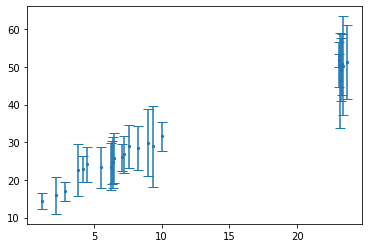

In [21]:
our_dist, our_dist_err, our_year_array = getCompsDistArray('c1')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C1')
#T21_mean_err = (T21_dist_upper + T21_dist_lower)/2
T21_dist, T21_mean_err, T21_year = getTValues('C1')

J3_dist = [48.14, 49.18, 52.66, 58.1, 61.70]
J3_dist_err = [3.2, 0.62, 0.64, 3.41, 2.21]
J3_year = [2008.44, 2008.9, 2009.68, 2010.56, 2011.25]

combined_dist = np.concatenate((T21_dist, our_dist))
combined_dist_err = np.concatenate((T21_mean_err, our_dist_err))
combined_year = np.concatenate((T21_year, our_year_array)) - 1990

plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year, combined_dist, s=5)

z = np.polyfit(combined_year, combined_dist, 1)
f = np.poly1d(z)
print(z)
print(f)


In [22]:
getTValues('C1')

(array([14.38506891, 15.91454461, 16.95997417, 22.67172083, 22.81412634,
        24.19631422, 23.33049531, 23.49734156, 24.74956409, 24.63282484,
        25.89122556, 26.04639735, 26.79239068, 28.87873622, 28.47500066,
        29.88631254, 28.89546155, 31.59039449]),
 array([ 4.0735399 ,  9.85994167,  5.2303894 , 13.68589681,  6.82511126,
         9.26118607, 10.68637549, 12.46064178, 11.41957042, 13.42359185,
        13.37662288,  7.1185232 ,  9.94391898, 11.52071138, 11.45701003,
        17.7105205 , 21.39022575,  7.55614604]),
 array([1991.17534247, 1992.23224044, 1992.89071038, 1993.8       ,
        1994.15616438, 1994.46575342, 1995.50136986, 1996.22404372,
        1996.32786885, 1996.41803279, 1996.49726776, 1997.06027397,
        1997.22465753, 1997.54794521, 1998.28219178, 1998.96438356,
        1999.32876712, 2000.03825137]))

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.682197325977987, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7211138596405373, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880982620257011, but should be close to 0.8. Try to increase the number of tuning steps.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  del sys.path[0]
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future re

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

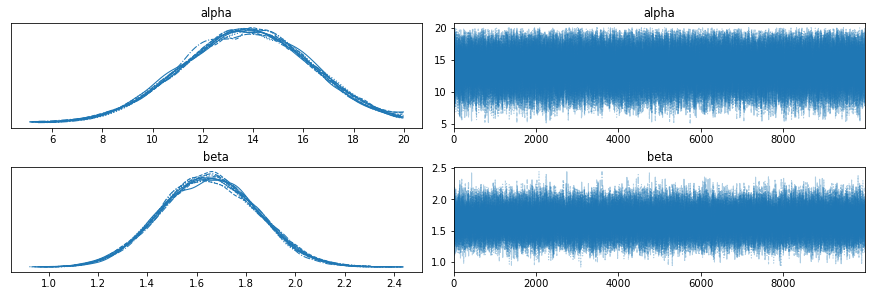

In [23]:
basic_model =  pm.Model()
with basic_model as bm:
        
    alpha = pm.Uniform('alpha', lower=5, upper=20)
    beta = pm.Uniform('beta', lower=0, upper=3)
    
    mu = alpha +  beta*combined_year
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
    step_method = pm.NUTS()
    traceC1 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(traceC1)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


(0.0, 40000.0)

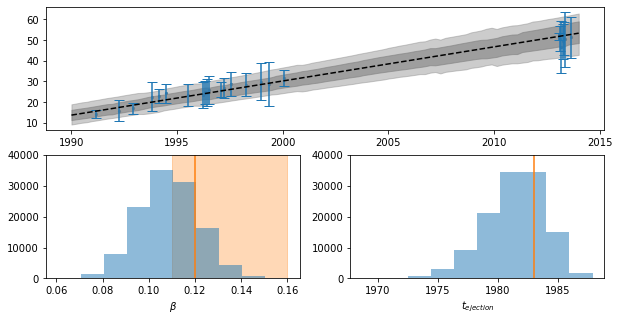

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.errorbar(combined_year + 1990, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year + 1990, combined_dist, s=5)

year_array = np.linspace(1990, 2014, 100)
fit_proper_motion = year_array*(np.median(traceC1['beta']))  + np.median(traceC1['alpha']) - (1990*np.median(traceC1['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed')



fit_trace = []

for i in range(2000):
    slope = mc_trace_sampler(traceC1['beta'])
    yIntercept = mc_trace_sampler(traceC1['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.6, color='grey', zorder=1)

upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.95).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=1)


plt.subplot(223)
plt.hist(traceC1['beta']*24/365.14, alpha=0.5, color=thisWorkColor, zorder=1)
plt.xlabel(r'$\beta$')
plt.vlines(0.12, 0, 50000, color=T21Color)
plt.ylim(0, 40000)
plt.axvspan(0.12 - 0.01, 0.12 + 0.04, alpha=0.3, color=T21Color, zorder=-1)

plt.subplot(224)
plt.hist(-traceC1['alpha']/ traceC1['beta'] + 1990, alpha=0.5, color=thisWorkColor)
plt.xlabel(r'$t_{ejection}$')
plt.vlines(1983, 0, 50000, color=T21Color)
plt.ylim(0, 40000)



### MCMC fitting for c2

[1.29695952 3.63812686]
 
1.297 x + 3.638


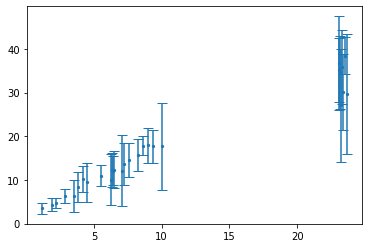

In [16]:
our_dist, our_dist_err, our_year_array = getCompsDistArray('c2')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C2')
#T21_mean_err = (T21_dist_upper + T21_dist_lower)/2
T21_dist, T21_mean_err, T21_year = getTValues('C2')

combined_dist = np.concatenate((T21_dist, our_dist))
combined_dist_err = np.concatenate((T21_mean_err, our_dist_err))
combined_year = np.concatenate((T21_year, our_year_array)) - 1990

plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year, combined_dist, s=5)

z = np.polyfit(combined_year, combined_dist, 1)
f = np.poly1d(z)
print(z)
print(f)
#plt.ylim(0, 60)

In [17]:
combined_dist

array([ 3.4562625 ,  4.34321732,  4.74009919,  6.34395621,  6.33720951,
        8.33536101, 10.24109132,  9.43929549, 11.00596736, 10.04901028,
       12.33015473, 12.12083116, 12.34698626, 12.10988624, 13.57749737,
       14.58197865, 15.80383592, 17.79989156, 17.91866262, 17.67221833,
       17.65243271, 36.6925237 , 35.06636396, 34.59490029, 27.04914282,
       35.79167988, 30.12255398, 38.48574262, 29.76127533])

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8796272819029809, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7113590317346978, but should be close to 0.8. Try to increase the number of tuning steps.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  del sys.path[0]
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model co

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

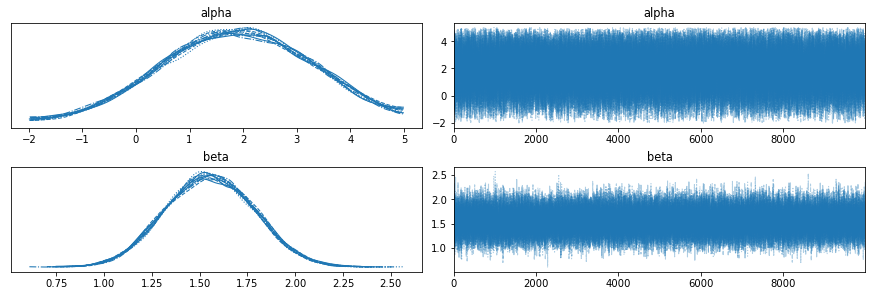

In [9]:
basic_model =  pm.Model()
with basic_model as bm:
        
    alpha = pm.Uniform('alpha', lower=-2, upper=5)
    beta = pm.Uniform('beta', lower=0, upper=3)
    
    mu = alpha +  beta*combined_year
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
    step_method = pm.NUTS()
    traceC2 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(traceC2)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


(0.0, 40000.0)

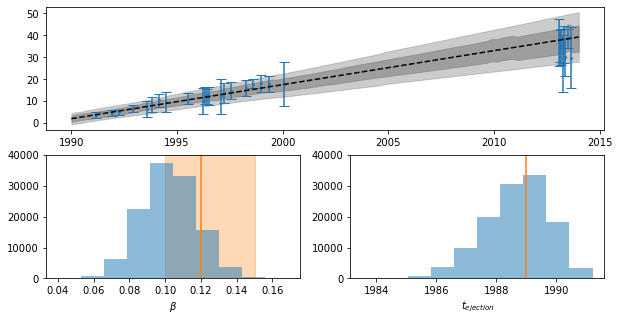

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.errorbar(combined_year + 1990, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year + 1990, combined_dist, s=5)

year_array = np.linspace(1990, 2014, 100)
fit_proper_motion = year_array*(np.median(traceC2['beta']))  + np.median(traceC2['alpha']) - (1990*np.median(traceC2['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed')

fit_trace = []

for i in range(2000):
    slope = mc_trace_sampler(traceC2['beta'])
    yIntercept = mc_trace_sampler(traceC2['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.6, color='grey', zorder=1)

upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.95).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=1)


plt.subplot(223)
plt.hist(traceC2['beta']*24/365.14, alpha=0.5, color=thisWorkColor, zorder=1)
plt.xlabel(r'$\beta$')
plt.vlines(0.12, 0, 50000, color=T21Color)
plt.ylim(0, 40000)
plt.axvspan(0.12 - 0.02, 0.12 + 0.03, alpha=0.3, color=T21Color, zorder=-1)

plt.subplot(224)
plt.hist(-traceC2['alpha']/ traceC2['beta'] + 1990, alpha=0.5, color=thisWorkColor)
plt.xlabel(r'$t_{ejection}$')
plt.vlines(1989, 0, 50000, color=T21Color)
plt.ylim(0, 40000)


### MCMC fitting for comp c3

[  2.19158766 -29.02398116]
 
2.192 x - 29.02


(0.0, 50.0)

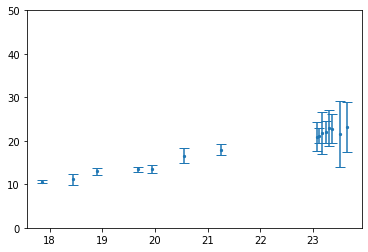

In [11]:
our_dist, our_dist_err, our_year_array = getCompsDistArray('c3')
T_mas_array, T_mas_err_array, T_year_array = getTANAMIValues('J7')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C2')
#T21_mean_err = (T21_dist_upper + T21_dist_lower)/2

combined_dist = np.concatenate((T_mas_array, our_dist))
combined_dist_err = np.concatenate((T_mas_err_array, our_dist_err))
combined_year = np.concatenate((T_year_array, our_year_array)) - 1990

plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year, combined_dist, s=5)

z = np.polyfit(combined_year, combined_dist, 1)
f = np.poly1d(z)
print(z)
print(f)
plt.ylim(0, 50)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8869839216957889, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995611992546261, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912307710647296, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893102501165735, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866165306943649, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

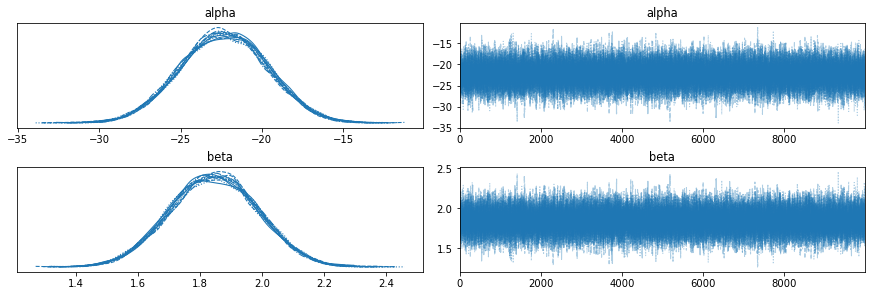

In [12]:
basic_model =  pm.Model()
with basic_model as bm:
        
    alpha = pm.Normal('alpha', mu=-21.84, sigma=3.64)
    beta = pm.Normal('beta', mu=1.82, sigma=0.25)
    #alpha = pm.Uniform('alpha', lower= -26, upper= -16)
    #beta = pm.Uniform('beta', lower=1, upper=2.5)
    
    mu = alpha +  beta*combined_year
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
    step_method = pm.NUTS()
    traceC3 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(traceC3)


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


(0.0, 40000.0)

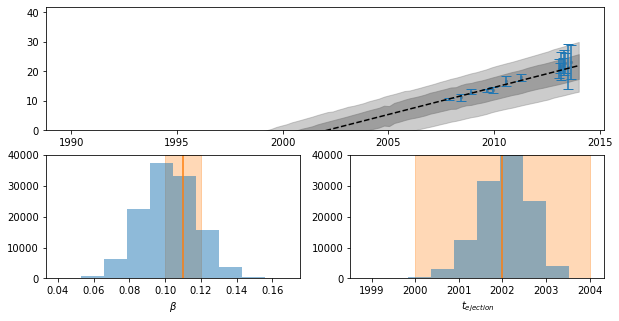

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.errorbar(combined_year + 1990, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year + 1990, combined_dist, s=5)

year_array = np.linspace(1990, 2014, 100)
fit_proper_motion = year_array*(np.median(traceC3['beta']))  + np.median(traceC3['alpha']) - (1990*np.median(traceC3['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed')

fit_trace = []

for i in range(2000):
    slope = mc_trace_sampler(traceC3['beta'])
    yIntercept = mc_trace_sampler(traceC3['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.6, color='grey', zorder=1)

upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.95).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=1)
plt.ylim(0, 42)

plt.subplot(223)
plt.hist(traceC2['beta']*24/365.14, alpha=0.5, color=thisWorkColor, zorder=1)
plt.xlabel(r'$\beta$')
plt.vlines(0.11, 0, 50000, color=T21Color)
plt.ylim(0, 40000)
plt.axvspan(0.11 - 0.01, 0.11 + 0.01, alpha=0.3, color=T21Color, zorder=-1)

plt.subplot(224)
plt.hist(-traceC3['alpha']/ traceC3['beta'] + 1990, alpha=0.5, color=thisWorkColor)
plt.xlabel(r'$t_{ejection}$')
plt.axvspan(2002 - 2, 2002 + 2, alpha=0.3, color=T21Color, zorder=-1)
plt.vlines(2002, 0, 50000, color=T21Color)
plt.ylim(0, 40000)


### MCMC fitting for c4

[  2.41447571 -44.681987  ]
 
2.414 x - 44.68


(0.0, 50.0)

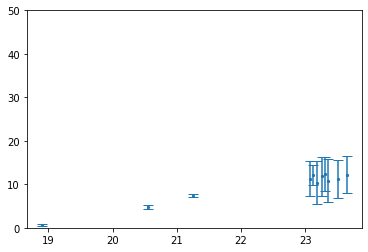

In [14]:
our_dist, our_dist_err, our_year_array = getCompsDistArray('c4')
T_mas_array, T_mas_err_array, T_year_array = getTANAMIValues('J10')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C2')
#T21_mean_err = (T21_dist_upper + T21_dist_lower)/2

combined_dist = np.concatenate((T_mas_array, our_dist))
combined_dist_err = np.concatenate((T_mas_err_array, our_dist_err))
combined_year = np.concatenate((T_year_array, our_year_array)) - 1990

plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year, combined_dist, s=5)

z = np.polyfit(combined_year, combined_dist, 1)
f = np.poly1d(z)
print(z)
print(f)
plt.ylim(0, 50)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8929821646290388, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897384209396825, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792192035026141, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  from ipykernel import kernelapp as app
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_py

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

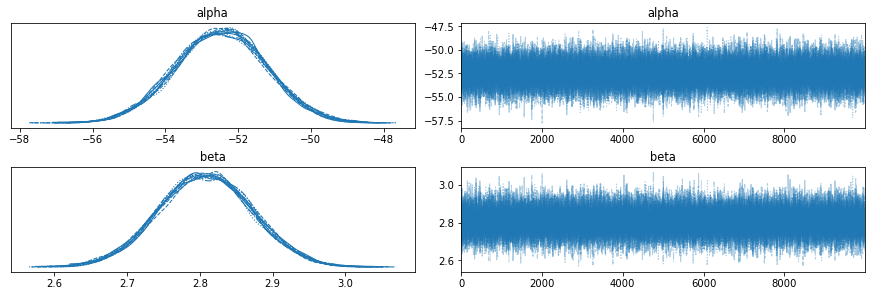

In [15]:
basic_model =  pm.Model()
with basic_model as bm:
        
    #alpha = pm.Uniform('alpha', lower=-55, upper=-45)
    #beta = pm.Uniform('beta', lower=2, upper=3.5)
    alpha = pm.Normal('alpha', mu=-52.36, sigma=1.415)
    beta = pm.Normal('beta', mu=2.83, sigma=0.14)
    
    mu = alpha +  beta*combined_year
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
    step_method = pm.NUTS()
    traceC4 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(traceC4)


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


(0.0, 40000.0)

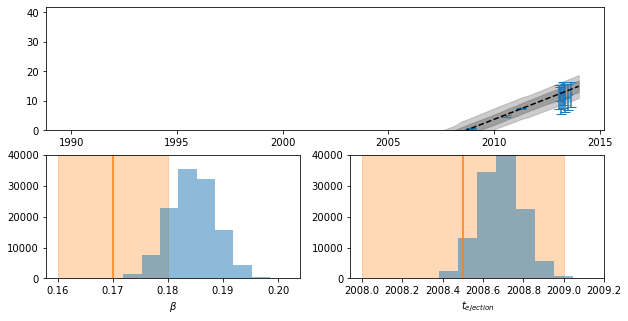

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.errorbar(combined_year + 1990, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year + 1990, combined_dist, s=5)

year_array = np.linspace(1990, 2014, 100)
fit_proper_motion = year_array*(np.median(traceC4['beta']))  + np.median(traceC4['alpha']) - (1990*np.median(traceC4['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed')

fit_trace = []

for i in range(2000):
    slope = mc_trace_sampler(traceC4['beta'])
    yIntercept = mc_trace_sampler(traceC4['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.6, color='grey', zorder=1)

upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.95).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=1)
plt.ylim(0, 42)

plt.subplot(223)
plt.hist(traceC4['beta']*24/365.14, alpha=0.5, color=thisWorkColor, zorder=1)
plt.xlabel(r'$\beta$')
plt.vlines(0.17, 0, 50000, color=T21Color)
plt.ylim(0, 40000)
plt.axvspan(0.17 - 0.01, 0.17 + 0.01, alpha=0.3, color=T21Color, zorder=-1)

plt.subplot(224)
plt.hist(-traceC4['alpha']/ traceC4['beta'] + 1990, alpha=0.5, color=thisWorkColor)
plt.xlabel(r'$t_{ejection}$')
plt.axvspan(2008.5 - 0.5, 2008.5 + 0.5, alpha=0.3, color=T21Color, zorder=-1)
plt.vlines(2008.5, 0, 50000, color=T21Color)
plt.ylim(0, 40000)


### MCMC modelling for c5

[-0.07866228  4.98256152]
 
-0.07866 x + 4.983


(0.0, 10.0)

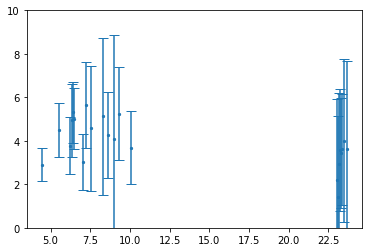

In [17]:
our_dist, our_dist_err, our_year_array = getCompsDistArray('c5')
T21_dist, T21_mean_err, T21_year = getTValues('C3')

combined_dist = np.concatenate((T21_dist, our_dist))
combined_dist_err = np.concatenate((T21_mean_err, our_dist_err))
combined_year = np.concatenate((T21_year, our_year_array)) - 1990

plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year, combined_dist, s=5)

z = np.polyfit(combined_year, combined_dist, 1)
f = np.poly1d(z)
print(z)
print(f)
plt.ylim(0, 10)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8803233640604662, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  del sys.path[0]
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

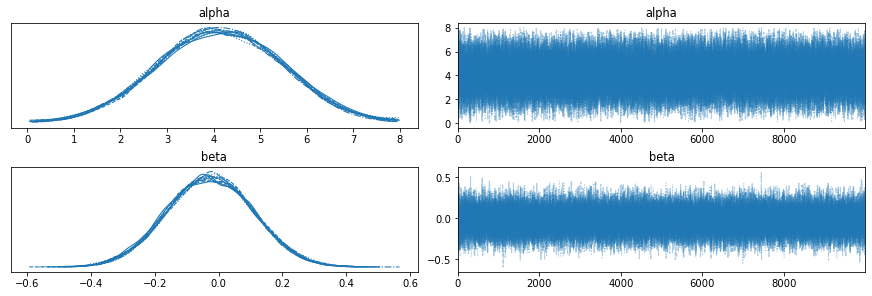

In [18]:
basic_model =  pm.Model()
with basic_model as bm:
        
    alpha = pm.Uniform('alpha', lower=0, upper=8)
    beta = pm.Uniform('beta', lower=-1, upper=1)
    
    mu = alpha +  beta*combined_year
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
    step_method = pm.NUTS()
    traceC5 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(traceC5)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


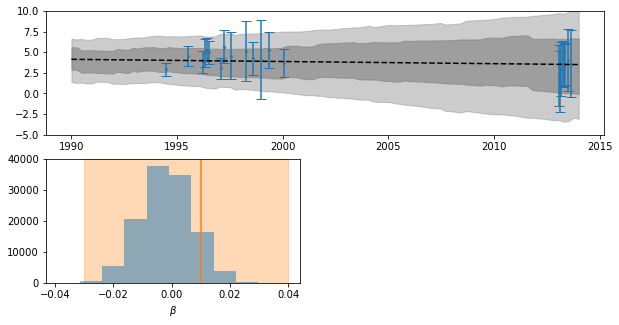

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.errorbar(combined_year + 1990, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year + 1990, combined_dist, s=5)

year_array = np.linspace(1990, 2014, 100)
fit_proper_motion = year_array*(np.median(traceC5['beta']))  + np.median(traceC5['alpha']) - (1990*np.median(traceC5['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed')

fit_trace = []

for i in range(2000):
    slope = mc_trace_sampler(traceC5['beta'])
    yIntercept = mc_trace_sampler(traceC5['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.6, color='grey', zorder=1)

upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.95).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=1)
plt.ylim(-5, 10)

plt.subplot(223)
plt.hist(traceC5['beta']*24/365.14, alpha=0.5, color=thisWorkColor, zorder=1)
plt.xlabel(r'$\beta$')
plt.vlines(0.01, 0, 50000, color=T21Color)
plt.ylim(0, 40000)
plt.axvspan(0.01 - 0.04, 0.01 + 0.03, alpha=0.3, color=T21Color, zorder=-1)



### MCMC for CJ1

In [20]:
# our_dist, our_dist_err, our_year_array = getCompsDistArray('cj1')
# # T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('CJ1')
# # T21_mean_err = (T21_dist_upper + T21_dist_lower)/2


# combined_dist = np.concatenate((T21_dist, our_dist))
# combined_dist_err = np.concatenate((T21_mean_err, our_dist_err))
# combined_year = np.concatenate((T21_year, our_year_array)) - 1990

# plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
# plt.scatter(combined_year, combined_dist, s=5)

# z = np.polyfit(combined_year, combined_dist, 1)
# f = np.poly1d(z)
# print(z)
# plt.ylim(0, 80)


In [21]:
# basic_model =  pm.Model()
# with basic_model as bm:
        
#     alpha = pm.Uniform('alpha', lower=20, upper=40)
#     beta = pm.Uniform('beta', lower=0, upper=1)
    
#     mu = alpha +  beta*combined_year
    
#     Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
#     step_method = pm.NUTS()
#     traceCJ1 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
# pm.traceplot(traceCJ1)

### MCMC for CJ 2

[ 0.02241319 14.34469212]
 
0.02241 x + 14.34


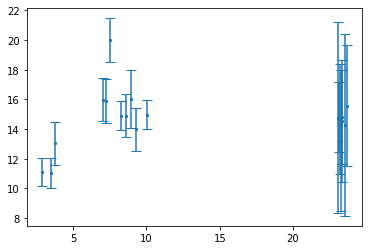

In [22]:
our_dist, our_dist_err, our_year_array = getCompsDistArray('cj2')
T21_dist, T21_mean_err, T21_year = getTValues('CJ2')
T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('CJ2')
T21_mean_err = (T21_dist_upper + T21_dist_lower)/2


combined_dist = np.concatenate((T21_dist, our_dist))
combined_dist_err = np.concatenate((T21_mean_err, our_dist_err))
combined_year = np.concatenate((T21_year, our_year_array)) - 1990

plt.errorbar(combined_year, combined_dist, yerr=combined_dist_err/2, fmt=' ', capsize=5)
plt.scatter(combined_year, combined_dist, s=5)

z = np.polyfit(combined_year, combined_dist, 1)
f = np.poly1d(z)
print(z)
print(f)
#plt.ylim(0, 50)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8953909632979412, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827894253875999, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  del sys.path[0]
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. 

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

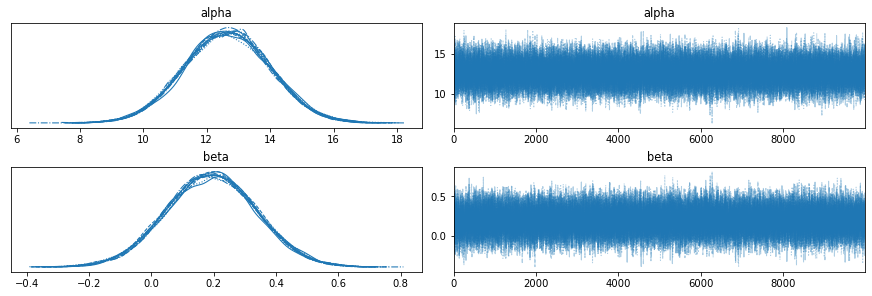

In [23]:
basic_model =  pm.Model()
with basic_model as bm:
        
    alpha = pm.Uniform('alpha', lower=5, upper=30)
    beta = pm.Uniform('beta', lower=-1, upper=1)
    
    mu = alpha +  beta*combined_year
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=combined_dist_err, observed = combined_dist)
    
    step_method = pm.NUTS()
    traceCJ2 = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(traceCJ2)

### summary plot

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherenc

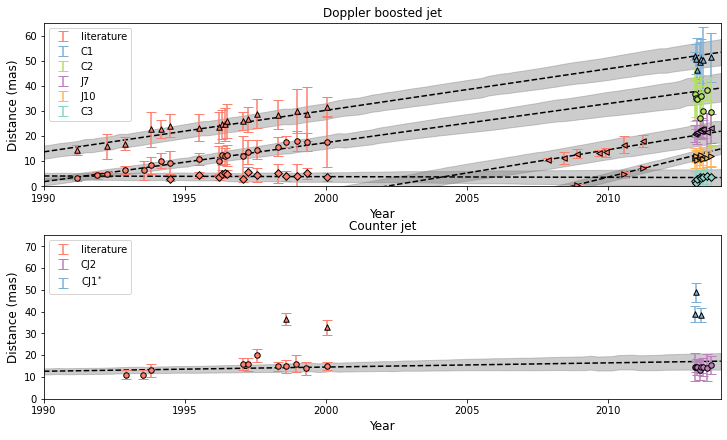

In [24]:
fig, ax =  plt.subplots(2,1, figsize=(10,6))
plt.subplots_adjust(left=0.05,
                    bottom=0.08,
                    right=0.99,
                    top=0.95,
                    wspace=0.15,
                    hspace=0.3)

hfont = {'fontname':'Helvetica', 'size':12}
hfont2 = {'fontname':'Helvetica', 'size':15}
#plt.style.use('ggplot')
mc_iter = 4000
#thisWorkColor = '#1f77b4'
thisWorkColor = '#7eb0d5'
T21Color = '#ff7f0e'
T21Color = '#fd7f6f'

plt.subplot(211)
## plot C1
our_dist, our_dist_err, our_year_array = getCompsDistArray('c1')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C1')
T21_dist, T21_mean_err, T21_year = getTValues('C1')
plt.errorbar(T21_year, T21_dist, yerr=T21_mean_err/2, fmt=' ', capsize=5, color=T21Color, alpha=1, label='literature', zorder=1)
plt.scatter(T21_year, T21_dist,facecolor=T21Color, s=30, alpha=1, zorder=1, marker='^', edgecolor='black')

plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label='C1', zorder=-1)
plt.scatter(our_year_array, our_dist,facecolor=thisWorkColor, edgecolor='black',s=30, alpha=1, zorder=1, marker='^')
plt.xlim(1990, 2014)
plt.title('Doppler boosted jet', **hfont)
plt.xlabel('Year', **hfont)
plt.ylabel('Distance (mas)', **hfont)
plt.ylim(0, 65)

year_array = np.linspace(1990, 2014, 100)
fit_proper_motion = year_array*(np.median(traceC1['beta']))  + np.median(traceC1['alpha']) - (1990*np.median(traceC1['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed', zorder=-4)

fit_trace = []

for i in range(mc_iter):
    slope = mc_trace_sampler(traceC1['beta'])
    yIntercept = mc_trace_sampler(traceC1['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=-5)


thisWorkColor = '#b2e061'
## c2
our_dist, our_dist_err, our_year_array = getCompsDistArray('c2')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C2')
T21_dist, T21_mean_err, T21_year = getTValues('C2')
plt.errorbar(T21_year, T21_dist, yerr=T21_mean_err/2, fmt=' ', capsize=5, color=T21Color, alpha=1, zorder=-1)
plt.scatter(T21_year, T21_dist,facecolor=T21Color, s=30, alpha=1, zorder=1, edgecolor='black', marker='o')

plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label='C2', zorder=-1)
plt.scatter(our_year_array, our_dist,facecolor=thisWorkColor, s=30, alpha=1, zorder=1, edgecolor='black', marker='o')


fit_proper_motion = year_array*(np.median(traceC2['beta']))  + np.median(traceC2['alpha']) - (1990*np.median(traceC2['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed', zorder=-4)

fit_trace = []

for i in range(mc_iter):
    slope = mc_trace_sampler(traceC2['beta'])
    yIntercept = mc_trace_sampler(traceC2['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=-5)


thisWorkColor = '#bd7ebe'
## c3
our_dist, our_dist_err, our_year_array = getCompsDistArray('c3')
T_mas_array, T_mas_err_array, T_year_array = getTANAMIValues('J7')
plt.errorbar(T_year_array, T_mas_array, yerr=T_mas_err_array, fmt=' ', capsize=5, color=T21Color, alpha=1, zorder=-1)
plt.scatter(T_year_array, T_mas_array,facecolor=T21Color, s=30, alpha=1, zorder=1, edgecolor='black', marker='<')

plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label='J7', zorder=-1)
plt.scatter(our_year_array, our_dist,facecolor=thisWorkColor, s=30, alpha=1, zorder=1, edgecolor='black', marker='<')


fit_proper_motion = year_array*(np.median(traceC3['beta']))  + np.median(traceC3['alpha']) - (1990*np.median(traceC3['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed', zorder=-4)

fit_trace = []

for i in range(mc_iter):
    slope = mc_trace_sampler(traceC3['beta'])
    yIntercept = mc_trace_sampler(traceC3['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=-5)


thisWorkColor = '#ffb55a'
## c4
our_dist, our_dist_err, our_year_array = getCompsDistArray('c4')
T_mas_array, T_mas_err_array, T_year_array = getTANAMIValues('J10')
plt.errorbar(T_year_array, T_mas_array, yerr=T_mas_err_array, fmt=' ', capsize=5, color=T21Color, alpha=1, zorder=-1)
plt.scatter(T_year_array, T_mas_array,facecolor=T21Color, s=30, alpha=1, zorder=1, edgecolor='black', marker='>')


plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label='J10', zorder=-1)
plt.scatter(our_year_array, our_dist,facecolor=thisWorkColor, s=30, alpha=1, zorder=1, marker='>', edgecolor='black')

fit_proper_motion = year_array*(np.median(traceC4['beta']))  + np.median(traceC4['alpha']) - (1990*np.median(traceC4['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed', zorder=-4)

fit_trace = []

for i in range(mc_iter):
    slope = mc_trace_sampler(traceC4['beta'])
    yIntercept = mc_trace_sampler(traceC4['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=-5)


thisWorkColor = '#8bd3c7'
## c5
our_dist, our_dist_err, our_year_array = getCompsDistArray('c5')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('C3')
T21_dist, T21_mean_err, T21_year = getTValues('C3')
plt.errorbar(T21_year, T21_dist, yerr=T21_mean_err/2, fmt=' ', capsize=5, color=T21Color, alpha=1, zorder=-1)
plt.scatter(T21_year, T21_dist,facecolor=T21Color, s=30, alpha=1, zorder=1, marker='D', edgecolor='black')

plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label=r'C3', zorder=-1)
plt.scatter(our_year_array, our_dist,facecolor=thisWorkColor, s=30, alpha=1, zorder=1, marker='D', edgecolor='black')


fit_proper_motion = year_array*(np.median(traceC5['beta']))  + np.median(traceC5['alpha']) - (1990*np.median(traceC5['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed', zorder=-4)

fit_trace = []

for i in range(mc_iter):
    slope = mc_trace_sampler(traceC5['beta'])
    yIntercept = mc_trace_sampler(traceC5['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=-5)
plt.legend()



# CJ2
thisWorkColor = '#bd7ebe'
plt.subplot(212)
our_dist, our_dist_err, our_year_array = getCompsDistArray('cj2')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('CJ2')
T21_dist, T21_mean_err, T21_year = getTValues('CJ2')
T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('CJ2')
T21_mean_err = (T21_dist_upper + T21_dist_lower)

plt.errorbar(T21_year, T21_dist, yerr=T21_mean_err/2, fmt=' ', capsize=5, color=T21Color, alpha=1, label='literature', zorder=-1)
plt.scatter(T21_year, T21_dist,color=T21Color, s=30, alpha=1, zorder=1, edgecolor='black', marker='o')

plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label='CJ2', zorder=-1)
plt.scatter(our_year_array, our_dist,color=thisWorkColor, s=30, alpha=1, marker='o', edgecolor='black', zorder=1)
plt.xlim(1990, 2014)

plt.title('Counter jet', **hfont)
plt.xlabel('Year', **hfont)

plt.ylabel('Distance (mas)', **hfont)
plt.ylim(0, 75)

fit_proper_motion = year_array*(np.median(traceCJ2['beta']))  + np.median(traceCJ2['alpha']) - (1990*np.median(traceCJ2['beta']))

plt.plot(year_array, fit_proper_motion, color='black', linestyle='dashed', zorder=-4)

fit_trace = []

for i in range(mc_iter):
    slope = mc_trace_sampler(traceCJ2['beta'])
    yIntercept = mc_trace_sampler(traceCJ2['alpha'])
    fit = year_array*slope + yIntercept - (1990*slope)
    fit_trace.append(fit)
 
upper_limit, lower_limit = az.hdi(np.array(fit_trace), hdi_prob=.68).T
plt.fill_between(year_array,upper_limit, lower_limit, alpha=0.4, color='grey', zorder=-5)


# CJ1
thisWorkColor = '#7eb0d5'
our_dist, our_dist_err, our_year_array = getCompsDistArray('cj1')
#T21_year, T21_dist, T21_dist_upper, T21_dist_lower = getT21Values('CJ1')
T21_dist, T21_mean_err, T21_year = getTValues('CJ1')
plt.errorbar(T21_year, T21_dist, yerr=T21_mean_err/2, fmt=' ', capsize=5, color=T21Color, alpha=1, zorder=-1)
plt.scatter(T21_year, T21_dist,facecolor=T21Color, s=30, alpha=1, marker='^', edgecolor='black', zorder=1)

plt.errorbar(our_year_array, our_dist, yerr=our_dist_err/2, fmt=' ', capsize=5, color=thisWorkColor, alpha=1, label=r'CJ1$^{*}$', zorder=-1)
plt.scatter(our_year_array, our_dist,facecolor=thisWorkColor, s=30, alpha=1, zorder=1, marker='^', edgecolor='black')

plt.legend()


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('properMotion.png', dpi=300)

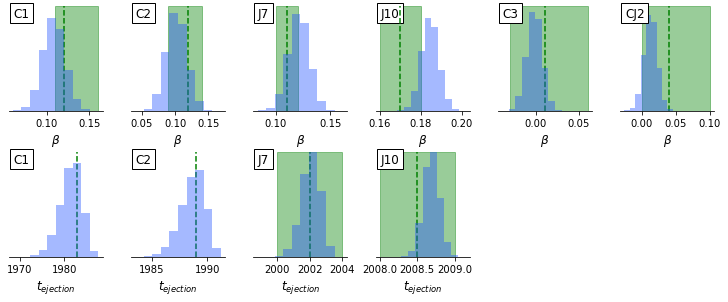

In [25]:
fig, ax =  plt.subplots(2,6, figsize=(10,4))
plt.subplots_adjust(left=0.01,
                    bottom=0.12,
                    right=0.99,
                    top=0.99,
                    wspace=0.3,
                    hspace=0.4)

hfont = {'fontname':'Helvetica', 'size':12}

T21Color = 'green'
thisWorkColor = '#1F51FF'
## c1
ax[0][0].hist(traceC1['beta']*24/365.14, alpha=0.4, color=thisWorkColor, zorder=1)
ax[0][0].set_xlabel(r'$\beta$', **hfont)
ax[0][0].yaxis.set_ticklabels([])
ax[0][0].set_yticks([])
ax[0][0].vlines(0.12, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[0][0].set_ylim(0, 40000)
ax[0][0].axvspan(0.12 - 0.01, 0.12 + 0.04, alpha=0.4, color=T21Color, zorder=-1)

ax[1][0].hist(-traceC1['alpha']/ traceC1['beta'] + 1990, alpha=0.4, color=thisWorkColor)
ax[1][0].yaxis.set_ticklabels([])
ax[1][0].set_yticks([])
ax[1][0].set_xlabel(r'$t_{ejection}$', **hfont)
ax[1][0].vlines(1983, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[1][0].set_ylim(0, 40000)


## c2
ax[0][1].hist(traceC2['beta']*24/365.14, alpha=0.4, color=thisWorkColor, zorder=1)
ax[0][1].set_xlabel(r'$\beta$', **hfont)
ax[0][1].yaxis.set_ticklabels([])
ax[0][1].set_yticks([])
ax[0][1].vlines(0.12, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[0][1].set_ylim(0, 40000)
ax[0][1].axvspan(0.12 - 0.03, 0.12 + 0.02, alpha=0.4, color=T21Color, zorder=-1)

ax[1][1].hist(-traceC2['alpha']/ traceC2['beta'] + 1990, alpha=0.4, color=thisWorkColor)
ax[1][1].yaxis.set_ticklabels([])
ax[1][1].set_yticks([])
ax[1][1].set_xlabel(r'$t_{ejection}$', **hfont)
ax[1][1].vlines(1989, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[1][1].set_ylim(0, 40000)


## c3 
ax[0][2].hist(traceC3['beta']*24/365.14, alpha=0.4, color=thisWorkColor, zorder=1)
ax[0][2].set_xlabel(r'$\beta$', **hfont)
ax[0][2].yaxis.set_ticklabels([])
ax[0][2].set_yticks([])
ax[0][2].vlines(0.11, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[0][2].set_ylim(0, 40000)
ax[0][2].axvspan(0.11 - 0.01, 0.11 + 0.01, alpha=0.4, color=T21Color, zorder=-1)

ax[1][2].hist(-traceC3['alpha']/ traceC3['beta'] + 1990, alpha=0.4, color=thisWorkColor)
ax[1][2].yaxis.set_ticklabels([])
ax[1][2].set_yticks([])
ax[1][2].set_xlabel(r'$t_{ejection}$', **hfont)
ax[1][2].vlines(2002, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[1][2].axvspan(2002 - 2, 2002 + 2, alpha=0.4, color=T21Color, zorder=-1)
ax[1][2].set_ylim(0, 40000)


## c4
ax[0][3].hist(traceC4['beta']*24/365.14, alpha=0.4, color=thisWorkColor, zorder=1)
ax[0][3].set_xlabel(r'$\beta$', **hfont)
ax[0][3].yaxis.set_ticklabels([])
ax[0][3].set_yticks([])
ax[0][3].vlines(0.17, 0, 50000, color=T21Color, zorder=9, linestyle='dashed')
ax[0][3].set_ylim(0, 40000)
ax[0][3].axvspan(0.17 - 0.01, 0.17 + 0.01, alpha=0.4, color=T21Color, zorder=-1)

ax[1][3].hist(-traceC4['alpha']/ traceC4['beta'] + 1990, alpha=0.4, color=thisWorkColor)
ax[1][3].yaxis.set_ticklabels([])
ax[1][3].set_yticks([])
ax[1][3].set_xlabel(r'$t_{ejection}$', **hfont)
ax[1][3].vlines(2008.5, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[1][3].axvspan(2008.5 - 0.5, 2008.5 + 0.5, alpha=0.4, color=T21Color, zorder=-1)
ax[1][3].set_ylim(0, 40000)


## c5
ax[0][4].hist(traceC5['beta']*24/365.14, alpha=0.4, color=thisWorkColor, zorder=1)
ax[0][4].set_xlabel(r'$\beta$', **hfont)
ax[0][4].yaxis.set_ticklabels([])
ax[0][4].set_yticks([])
ax[0][4].vlines(0.01, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[0][4].set_ylim(0, 40000)
ax[0][4].axvspan(0.01 - 0.04, 0.03 + 0.03, alpha=0.4, color=T21Color, zorder=-1)

## cJ2
ax[0][5].hist(traceCJ2['beta']*24/365.14, alpha=0.4, color=thisWorkColor, zorder=1)
ax[0][5].set_xlabel(r'$\beta$', **hfont)
ax[0][5].yaxis.set_ticklabels([])
ax[0][5].set_yticks([])
ax[0][5].vlines(0.04, 0, 50000, color=T21Color, zorder=0, linestyle='dashed')
ax[0][5].set_ylim(0, 40000)
ax[0][5].axvspan(0.04 - 0.04, 0.04 + 0.06, alpha=0.4, color=T21Color, zorder=-1)


fig.delaxes(ax[1][4])
fig.delaxes(ax[1][5])

ax[0][0].annotate('C1', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[0][1].annotate('C2', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[0][2].annotate('J7', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[0][3].annotate('J10', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[0][4].annotate(r'C3', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[0][5].annotate('CJ2', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))


ax[1][0].annotate('C1', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[1][1].annotate('C2', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[1][2].annotate('J7', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))

ax[1][3].annotate('J10', (0.05, 0.9), xycoords='axes fraction',
                fontsize=12, 
                bbox=dict(boxstyle='square', facecolor='white'))


ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)

ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)

ax[0][2].spines['right'].set_visible(False)
ax[0][2].spines['left'].set_visible(False)
ax[0][2].spines['top'].set_visible(False)

ax[0][3].spines['right'].set_visible(False)
ax[0][3].spines['left'].set_visible(False)
ax[0][3].spines['top'].set_visible(False)

ax[0][4].spines['right'].set_visible(False)
ax[0][4].spines['left'].set_visible(False)
ax[0][4].spines['top'].set_visible(False)

ax[0][5].spines['right'].set_visible(False)
ax[0][5].spines['left'].set_visible(False)
ax[0][5].spines['top'].set_visible(False)



ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)

ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)

ax[1][2].spines['right'].set_visible(False)
ax[1][2].spines['left'].set_visible(False)
ax[1][2].spines['top'].set_visible(False)

ax[1][3].spines['right'].set_visible(False)
ax[1][3].spines['left'].set_visible(False)
ax[1][3].spines['top'].set_visible(False)

ax[1][3].yaxis.set_ticks([])


# ## set scales for tejection
# ax[1][0].set_xlim(1978, 1978 + 8)
# ax[1][1].set_xlim(1985, 1985 + 8)
# ax[1][2].set_xlim(1998, 1998 + 8)
# ax[1][3].set_xlim(2005, 2005 + 8)

# ## set axis lim for beta
# ax[0][0].set_xlim(-0.03, 0.2)
# ax[0][1].set_xlim(-0.03, 0.2)
# ax[0][2].set_xlim(-0.03, 0.2)
# ax[0][3].set_xlim(-0.03, 0.2)
# ax[0][4].set_xlim(-0.03, 0.2)
# ax[0][5].set_xlim(-0.03, 0.2)


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('componentSpeeds.png', dpi=300)

### calculate inclination angles

In [34]:
theta_fastest_comp = []
theta_slowest_comp = []
def getTheta(b_r, b_a):
    return np.degrees(np.arctan2(2*b_a*b_r, b_a - b_r))

for i in range(5000):
    br = traceCJ2['beta'][i]
    ba = traceC4['beta'][i]
    theta = getTheta(br, ba)
    theta_fastest_comp.append(theta)
    
    ba = traceC1['beta'][i]
    theta = getTheta(br, ba)
    theta_slowest_comp.append(theta)
    
    


Text(0.5, 0, 'inclination angle (deg)')

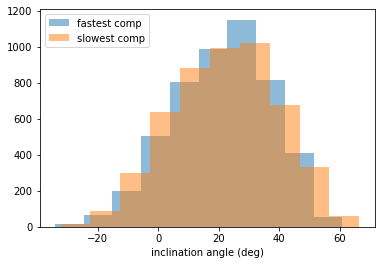

In [35]:
plt.hist(theta_fastest_comp, label='fastest comp', alpha=0.5)

plt.hist(theta_slowest_comp, label='slowest comp', alpha=0.5)

plt.legend()
plt.xlabel('inclination angle (deg)')

In [36]:
print(np.mean(theta_slowest_comp))
print(np.std(theta_slowest_comp))

22.30405130634876
17.200357431886605


### get range of brighness ratios

### use only C1, C2, and J7 cos everything is at optically thick part of the jet

In [59]:
def getBO04Values(compName):
    
    epoch_list = [1, 2, 3, 4, 5, 6, 12]
    light_array = []
    
    for epoch in epoch_list:
    
        modelFile = '../properMotion/epoch{}modelfitLabledV2.mod'.format(epoch)
        f = open(modelFile, 'r')
        for line in f:
        
            if line[0] == '!':
                continue
                

            parms = line.split()
            local_compName = parms[-1]
                    
            if local_compName == compName:
                
                light = parms[0]
            
                if light[-1] == 'v':
                    light = light[:-1]
                    
                light = float(light)
                    
                light_array.append(light)
                
                
                                
            

    return np.array(light_array)


In [136]:
c1_light = getBO04Values('c1')
c2_light = getBO04Values('c2')
c3_light = getBO04Values('c3')
c4_light = getBO04Values('c4')



cj2_light = getBO04Values('cj2')

r_array = []

for c1 in c1_light:    
    for cj2 in cj2_light:
        r= c1/cj2
        r_array.append(r)

for c2 in c2_light:    
    for cj2 in cj2_light:
        r= c2/cj2
        r_array.append(r)

for c3 in c3_light:    
    for cj2 in cj2_light:
        r= c3/cj2
        r_array.append(r)

for c4 in c4_light:    
    for cj2 in cj2_light:
        r= c4/cj2
        r_array.append(r)



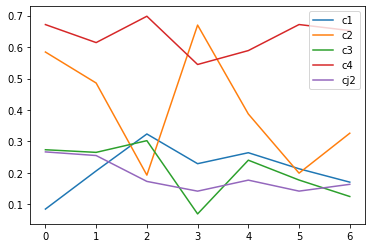

In [137]:
plt.plot(c1_light, label='c1')
plt.plot(c2_light, label='c2')
plt.plot(c3_light, label='c3')
plt.plot(c4_light, label='c4')

plt.plot(cj2_light, label='cj2')
plt.legend()




(array([23., 34., 40., 21., 21., 10., 10., 15., 12., 10.]),
 array([0.26083401, 0.72647945, 1.19212488, 1.65777032, 2.12341575,
        2.58906119, 3.05470662, 3.52035206, 3.98599749, 4.45164293,
        4.91728836]),
 <BarContainer object of 10 artists>)

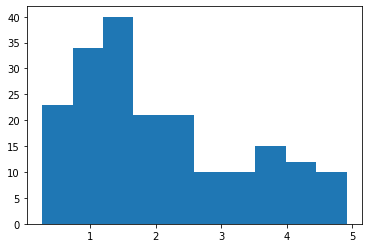

In [142]:
plt.hist(r_array)

In [143]:
print(min(r_array))
print(max(r_array))

0.2608340113456138
4.917288360067911


In [144]:
def getBeta(r, theta):
    return (r**(1/3) - 1)/(np.cos(np.radians(theta))*(r**(1/3) + 1))

(0.0, 1.0)

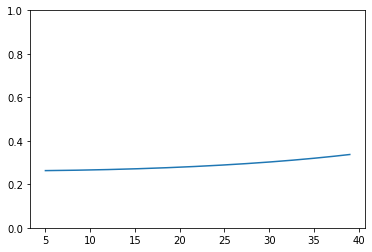

In [152]:
theta_array = np.linspace(5, 39, 1000)

beta2_array = getBeta(5, theta_array)


plt.plot(theta_array, beta2_array)

plt.ylim(0, 1)


In [153]:
np.max(beta2_array)

0.33711308104436344